In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler, SMOTE, KMeansSMOTE,BorderlineSMOTE, SVMSMOTE, KMeansSMOTE, ADASYN
from imblearn.under_sampling import ClusterCentroids, RandomUnderSampler, NearMiss, TomekLinks, EditedNearestNeighbours, RepeatedEditedNearestNeighbours, AllKNN,CondensedNearestNeighbour,OneSidedSelection,NeighbourhoodCleaningRule
from imblearn.combine import SMOTEENN,  SMOTETomek
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn.ensemble import ExtraTreesRegressor,RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import time
import missingno as msno
import sys
plt.rcParams.update({'figure.max_open_warning': 0})
sys.path.insert(1, '../Scripts')
from funciones import simbologia, graficar2, Histogramas

In [2]:
def Colores(Y):
    Dpal = {}
    for i, ID in enumerate(np.unique(Y)):
        volcan = df.Volcan.cat.categories[ID]
        #print(volcan)
        color, marker = simbologia(volcan,'Unknown')
        Dpal[volcan] = color
    return Dpal

def Histogramas(Data_temp):
    for elemento in Data_temp.columns:
        if (elemento != 'Volcan')&(elemento != 'Evento'):  
            print(" ")
            print('\033[1m'+ elemento + '\033[0m')
            for i in Data_temp.Volcan.unique():
                #print(i)
                coloR, Marker  = simbologia(i,'Unknown')
                Data_volcan =Data_temp[Data_temp['Volcan']==i]
                if pd.isnull(Data_volcan[elemento]).all():
                    print('Volcán without information {}'.format(i))              
                else:
                    plt.hist(Data_volcan[elemento] ,label= i, color = coloR, alpha= 0.3,range=(np.nanmin(Data_volcan[elemento]), np.nanmax(Data_volcan[elemento])))  
    
            plt.gca().set(xlabel=elemento,ylabel='Frequency')
            plt.legend(bbox_to_anchor=(1,1),ncol=2)
            plt.show()
            
def graficar_imputing(est,X,X_imp,y,A,B):
    dpal = Colores(y)
    fig, axes = plt.subplots(1, 2, figsize=(15,5),sharex=True,sharey=True)
    sns.scatterplot(X.loc[:, A], X.loc[:, B],
                hue=df.Volcan.cat.categories[y], alpha=0.7, palette=dpal, ax=axes[0])
    axes[0].set_title("Original data",fontsize=14)
    axes[0].legend(loc='center left', bbox_to_anchor=(0, -0.4), ncol=3)
    #axes[0].set_xlim([40,80]);axes[0].set_ylim([0,5])
    #sns.scatterplot(X.loc[:, A], X.loc[:, B],
    #            hue=df.Volcan.cat.categories[y], alpha=0.7, palette=dpal, ax=axes[1])
    sns.scatterplot(X_imp.loc[:, A], X_imp.loc[:, B],
                alpha=0.7, hue=df.Volcan.cat.categories[y], ax=axes[1], palette=dpal,s=30)
    #sns.scatterplot(X_imp.loc[:, A], X_imp.loc[:, B],
    #            alpha=0.7, ax=axes[1], marker='x', color='k',s=30)
    axes[1].set_title(est,fontsize=14)
    axes[1].legend(loc='center left', bbox_to_anchor=(0, -0.6), ncol=3)
    #axes[1].set_xlim([40,80]);axes[0].set_ylim([0,5])

In [3]:
np.random.seed(0)

In [9]:
# Load the data
df = pd.read_excel('../Data/TephraDataBase.xlsx')

In [10]:
#there are some samples in which the value of a determined element is marked "0" which is not possible to determined. thus I think they should be replaced by below detection limit which seems more accurate
for elemento in ["SiO2","TiO2","Al2O3","FeO","Fe2O3","MnO","MgO","CaO","Na2O","K2O","P2O5","Cl",'Rb','Sr','Y','Zr','Nb','Cs','Ba','La','Ce','Pr','Nd','Sm','Eu','Gd','Tb','Dy','Ho','Er','Tm','Yb','Lu','Hf','Ta','Pb','Th','U']:
    df[elemento] = df[elemento].replace(to_replace=0, value='bdl')
#without doing this 203 rows are eliminated. doing this. 795

In [11]:
#dropping rows where value are Missing Not At Random
for columna in df.columns:
    df=df[(df[columna]!= 'Over range')&(df[columna]!= 'b.d.l.')&(df[columna]!= 'bdl')&(df[columna]!= '<1')&(df[columna]!= '<0.1')&(df[columna]!= '<5')&(df[columna]!= '<10')&(df[columna]!= '<5')&(df[columna]!= '<6')]
print(df.shape)    

(15905, 82)


In [12]:
# 1 - Convert geochemical columns to float type
#Missing Not at Random
#df = df.replace(to_replace='Over range', value=np.nan)
#df = df.replace(to_replace='bdl', value=np.nan)
#df = df.replace(to_replace='<5', value=np.nan)
#df = df.replace(to_replace='<10', value=np.nan)
#df = df.replace(to_replace='<4', value=np.nan)
#df = df.replace(to_replace='<6', value=np.nan)
#df = df.replace(to_replace='<0.1', value=0.1)#0.1 
#df = df.replace(to_replace='<1', value=1)#1

#Missing at random
df = df.replace(to_replace='n.a.', value=np.nan)
df = df.replace(to_replace='Not analyzed', value=np.nan)
df = df.replace(to_replace='-', value=np.nan)
df = df.replace(to_replace='Not determined', value=np.nan)
df = df.replace(to_replace='<0.01', value=0.01)#.01 esto es LOI así que da lo misme
df = df.replace(to_replace='n.d', value=np.nan)

#df['ZrNb'] = df['Zr'].values/df['Nb'].values  
#df['LaYb'] = df['La'].values/df['Yb'].values

# 1.2 - Drop FeO, FeO2, LOI and Total
df = df.drop(['Fe2O3','FeO','LOI','Total','87Sr/86Sr','2SE','CodigoLaboratorioRadiocarbono','Mapa?'], axis=1)

# 1.3 - Drop Samples labeled as Prueba (in Spanish "test"), Subsidiary Vcha dome which is an unidentified Volcano
#        and samples measured by 'Accelerator Mass Spectrometry' which is used to measure age and not geochemistry
df = df[(df.Volcan != 'Prueba')&(df.Volcan != 'Subsidiary Vcha dome')]
df = df[(df.TipoDeRegistro != 'Organic matter')]

# 1.4 - Filter samples with Flag 4 == problems in geochemistry 
print('Number of samples with doutfull geochemistry: {}'.format(df[df.Flag == 4].shape[0]))
df.Flag = df.Flag.astype(str)
df = df[(df.Flag.str.contains('Outlier') == False)&(df.Flag.str.contains('4') == False)]
 
# here additionally the samples for which a problem in the classification of the sample has been indicated in the 
# literature might also be done. corresponding to Flag == 3
print('Number of samples with doutfull classification: {}'.format(df[df.Flag == '3'].shape[0]))

Number of samples with doutfull geochemistry: 89
Number of samples with doutfull classification: 227


In [13]:
df.loc[:, 'SiO2':'U'] = df.loc[:, 'SiO2':'U'].astype('float')

In [14]:
# 2 - Filter samples for which volcano id is unknown
df_unknown = df.query('Volcan == "Unknown"')
df = df.query('Volcan != "Unknown"').copy()

In [15]:
#df = df[df.Volcan.isin(['Quetrupillán','Yate','Llaima','Hudson','Mocho-Choshuenco','Villarrica','Maca','Corcovado'])]
#df = df[df.Volcan.isin(['Villarrica','Mocho-Choshuenco','Corcovado','Aguilera','Cay','Llaima','Huequi','Maca'])]
#df = df.query(('Volcan != "Yanteles"')).copy()
df = df.query(('Volcan != "Cordón Cabrera"')).copy()
#df = df.query(('Volcan != "Corcovado"')).copy()
#df = df.query(('Volcan != "Cay"')).copy()
#df = df.query(('Volcan != "Macá"')).copy()
#df = df.dropna(axis = 'rows',subset=(['SiO2']))


In [16]:
# The list of volcanoes and associated codes
df['Volcan'] = df['Volcan'].astype("category")
df['Volcan'].cat.categories
y = np.array(df['Volcan'].cat.codes)

# The list of IDs and associated codes
df['SampleID'] = df['SampleID'].astype("category")
df['SampleID'].cat.categories
SampleID = np.array(df['SampleID'].cat.codes)

In [17]:
# Print number of samples per class
unique, counts = np.unique(y, return_counts=True)
for u, c in zip(unique, counts):
    print('id: {}, volcán: \033[1m{}\033[0m, count: {}'.format(u,df.Volcan.cat.categories[u],c))

n_classes = len(unique)

id: 0, volcán: Aguilera, count: 25
id: 1, volcán: Antillanca-Casablanca, count: 198
id: 2, volcán: Apagado, count: 44
id: 3, volcán: Burney, count: 347
id: 4, volcán: Caburga-Huelemolle, count: 133
id: 5, volcán: Calbuco, count: 151
id: 6, volcán: Carrán-Los Venados, count: 114
id: 7, volcán: Cay, count: 17
id: 8, volcán: Chaitén, count: 2252
id: 9, volcán: Corcovado, count: 5
id: 10, volcán: Hornopirén, count: 21
id: 11, volcán: Huanquihue Group, count: 176
id: 12, volcán: Hudson, count: 921
id: 13, volcán: Huequi, count: 11
id: 14, volcán: Lanín, count: 81
id: 15, volcán: Lautaro, count: 34
id: 16, volcán: Llaima, count: 1176
id: 17, volcán: Macá, count: 22
id: 18, volcán: Melimoyu, count: 457
id: 19, volcán: Mentolat, count: 103
id: 20, volcán: Michinmahuida, count: 500
id: 21, volcán: Mocho-Choshuenco, count: 2661
id: 22, volcán: Osorno, count: 96
id: 23, volcán: Puyehue-Cordón Caulle, count: 1838
id: 24, volcán: Quetrupillán, count: 1129
id: 25, volcán: Reclus, count: 143
id: 26, 

In [18]:
# 3 - Retrieve the geochemical data
X_major = df.loc[:, 'SiO2':'K2O']
X_traces = df.loc[:, 'Rb':'U']
X = pd.concat( [X_major, X_traces], axis=1)#df.loc[:, 'SampleID'] ,

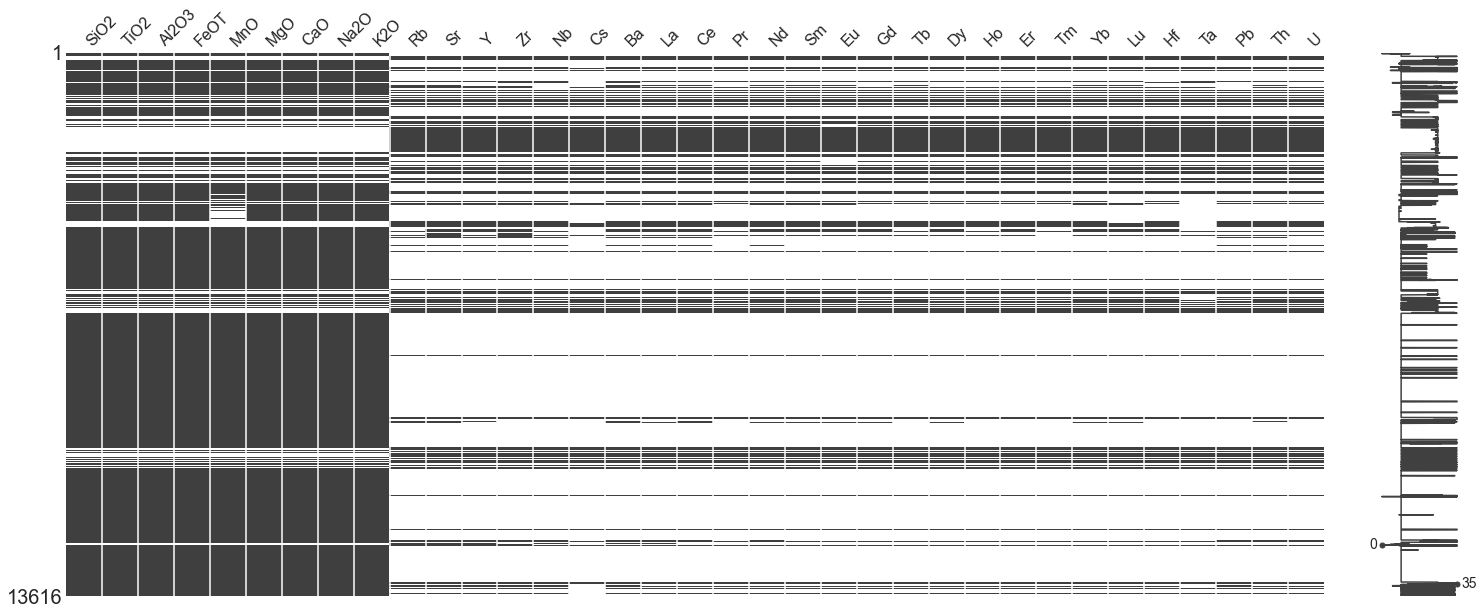

In [19]:
msno.matrix(X)

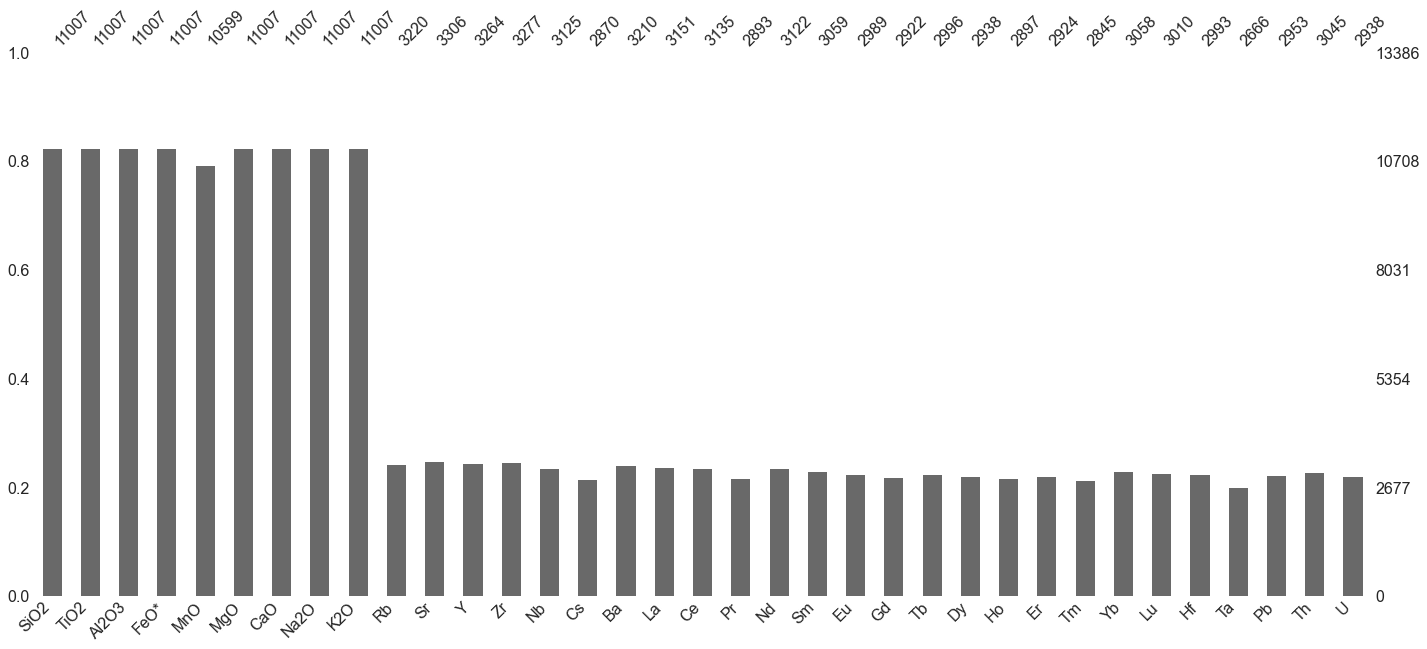

In [15]:
msno.bar(X)

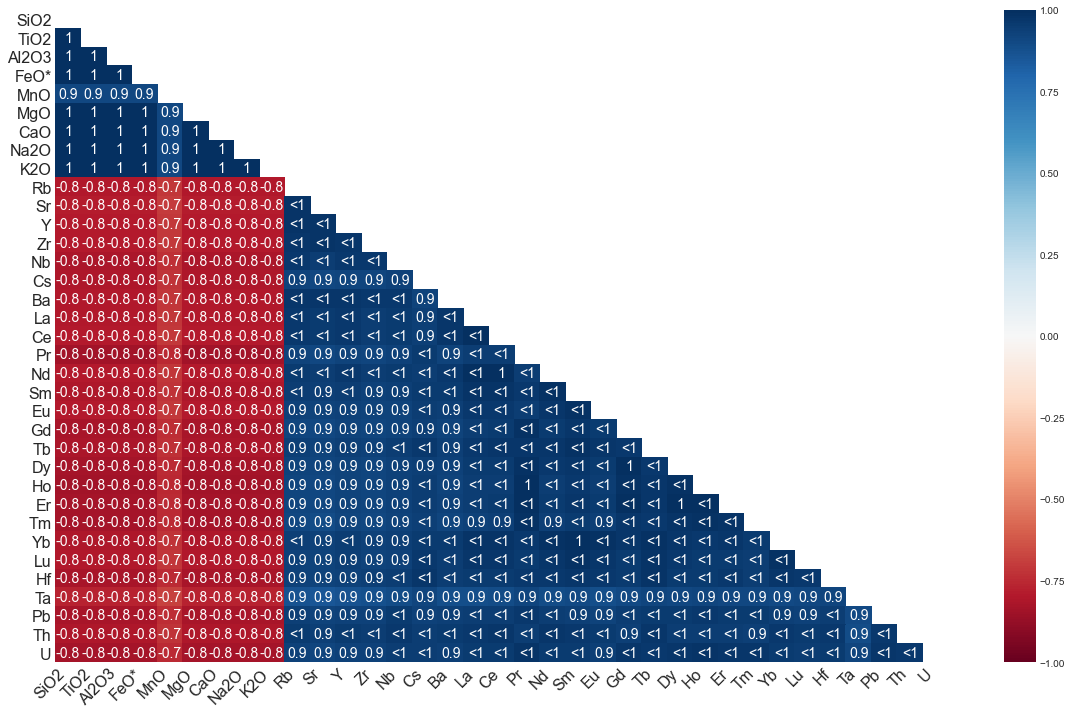

In [16]:
msno.heatmap(X) #nullity correlation

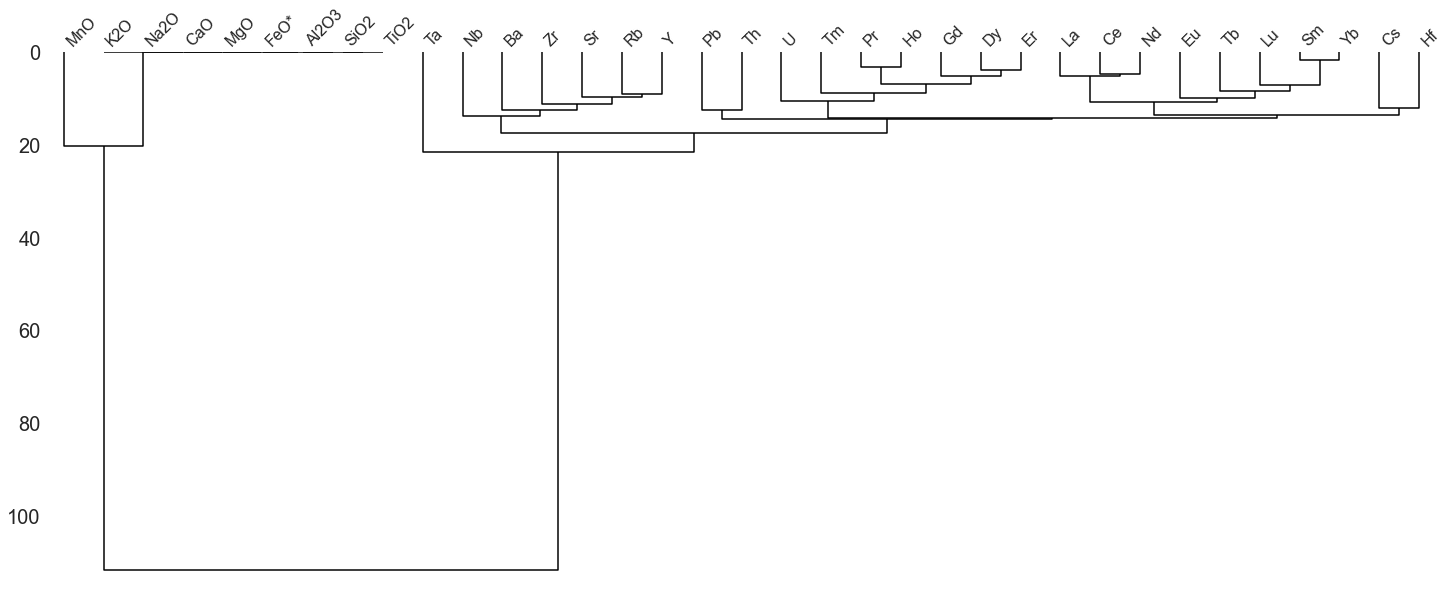

In [17]:
msno.dendrogram(X)

In [64]:
print(df.SiO2.mean(axis=0))
print(df.K2O.mean(axis=0))
print(df.Rb.mean(axis=0))
print(df.Sr.mean(axis=0))

65.02234389946705
2.090248620908222
76.62297923205917
264.26479435258807


# Original Data

(5052, 35)


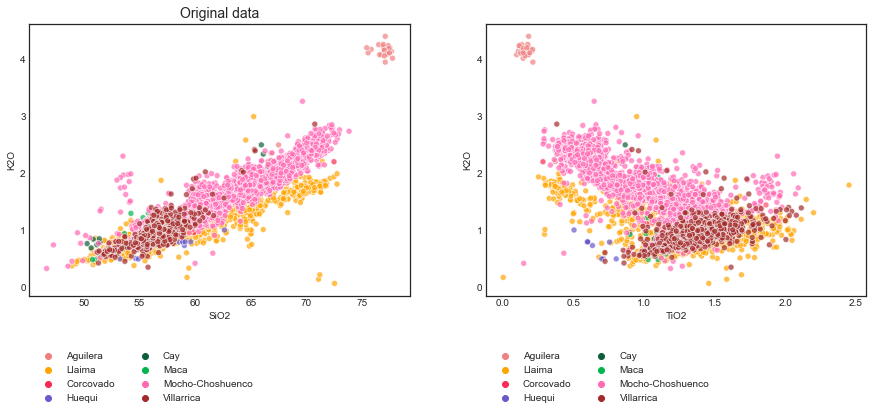

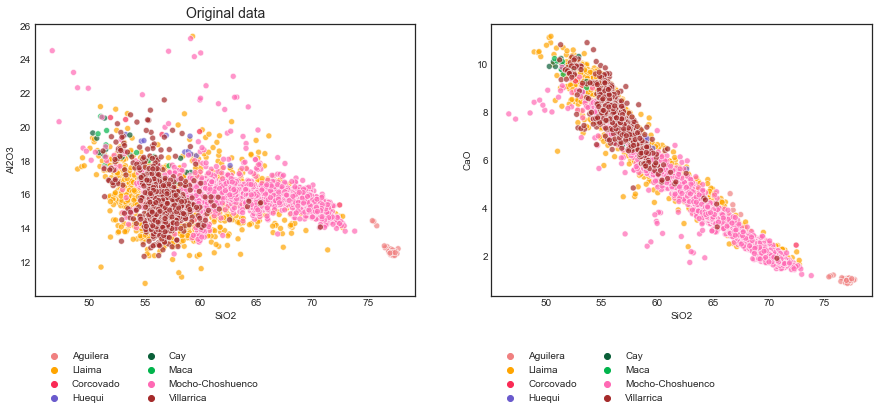

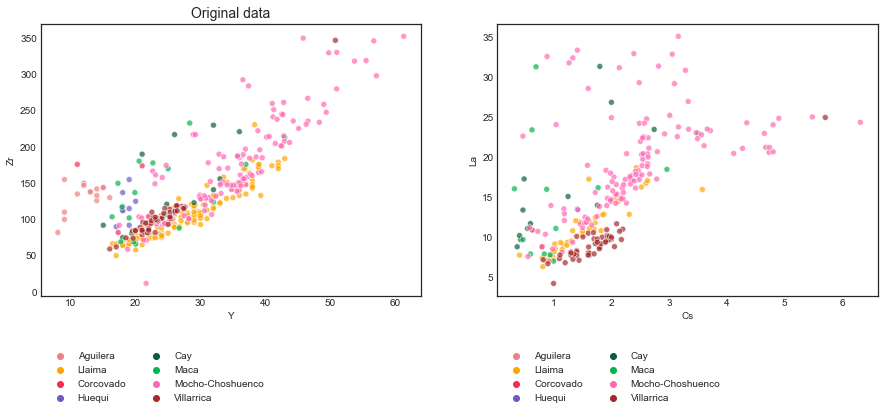

In [22]:
dpal = Colores(y)
print(X.shape)
fig, axes = plt.subplots(1, 2, figsize=(15,5))
sns.scatterplot(X.loc[:, 'SiO2'], X.loc[:, 'K2O'],
                hue=df.Volcan.cat.categories[y], alpha=0.7, palette=dpal, ax=axes[0])
axes[0].legend(loc='center left', bbox_to_anchor=(0, -0.3), ncol=2)
axes[0].set_title("Original data",fontsize=14)
sns.scatterplot(X.loc[:, 'TiO2'], X.loc[:, 'K2O'],
                hue=df.Volcan.cat.categories[y], alpha=0.7, palette=dpal, ax=axes[1])
axes[1].legend(loc='center left', bbox_to_anchor=(0, -0.3), ncol=2)

fig, axes = plt.subplots(1, 2, figsize=(15,5))
sns.scatterplot(X.loc[:, 'SiO2'], X.loc[:, 'Al2O3'],
                hue=df.Volcan.cat.categories[y], alpha=0.7, palette=dpal, ax=axes[0])
axes[0].legend(loc='center left', bbox_to_anchor=(0, -0.3), ncol=2)
axes[0].set_title("Original data",fontsize=14)
sns.scatterplot(X.loc[:, 'SiO2'], X.loc[:, 'CaO'],
                hue=df.Volcan.cat.categories[y], alpha=0.7, palette=dpal, ax=axes[1])
axes[1].legend(loc='center left', bbox_to_anchor=(0, -0.3), ncol=2)

fig, axes = plt.subplots(1, 2, figsize=(15,5))
sns.scatterplot(X.loc[:, 'Y'], X.loc[:, 'Zr'],
                hue=df.Volcan.cat.categories[y], alpha=0.7, palette=dpal, ax=axes[0])
axes[0].legend(loc='center left', bbox_to_anchor=(0, -0.3), ncol=2)
axes[0].set_title("Original data",fontsize=14)
sns.scatterplot(X.loc[:, 'Cs'], X.loc[:, 'La'],
                hue=df.Volcan.cat.categories[y], alpha=0.7, palette=dpal, ax=axes[1])
axes[1].legend(loc='center left', bbox_to_anchor=(0, -0.3), ncol=2)

## Escaling

65.02234389946705
264.26479435258807
 
SiO2


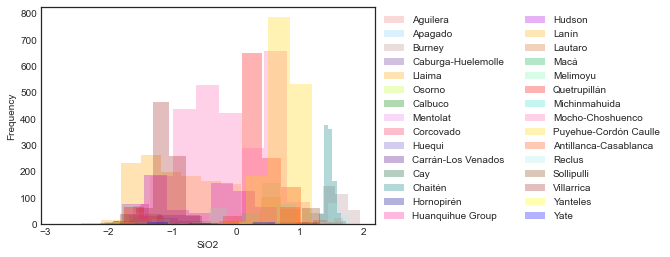

 
TiO2


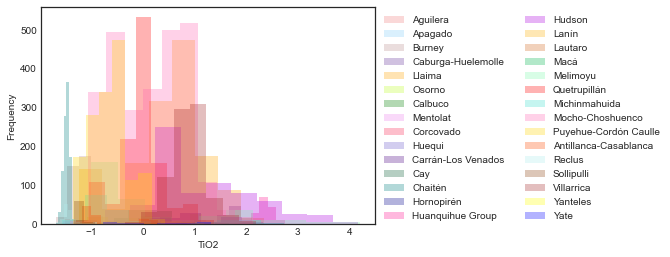

 
Al2O3


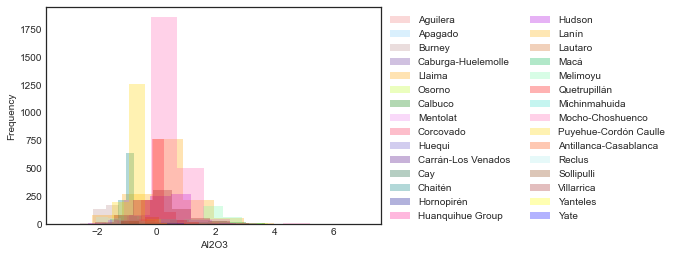

 
FeO*


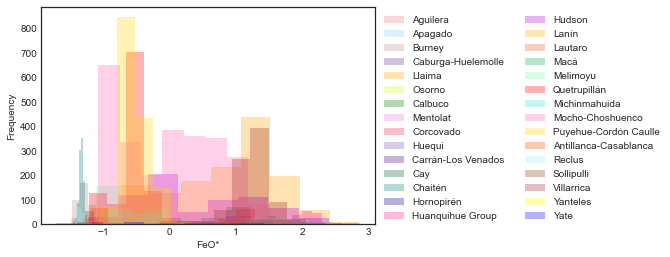

 
MnO


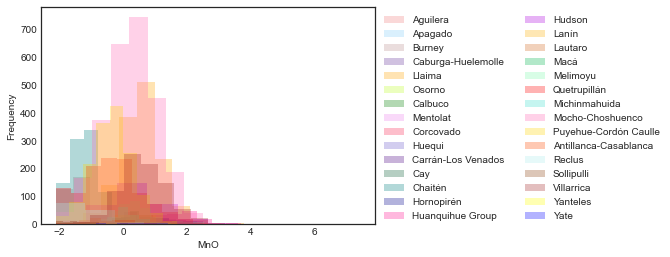

 
MgO


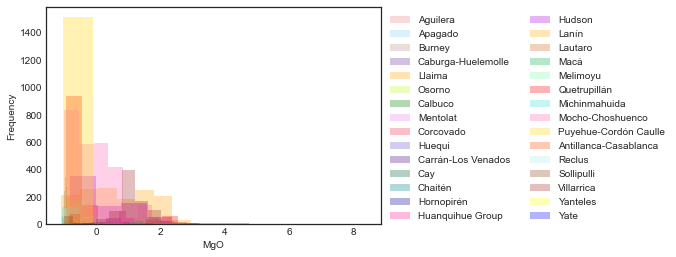

 
CaO


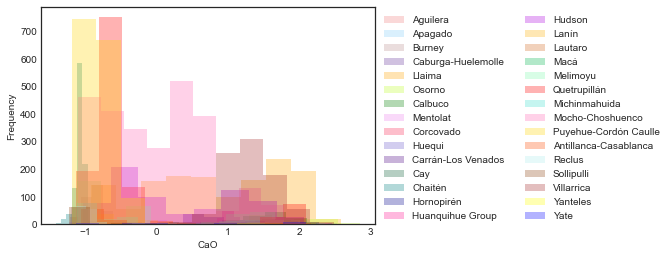

 
Na2O


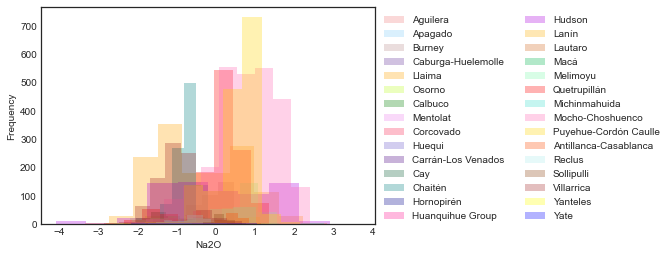

 
K2O


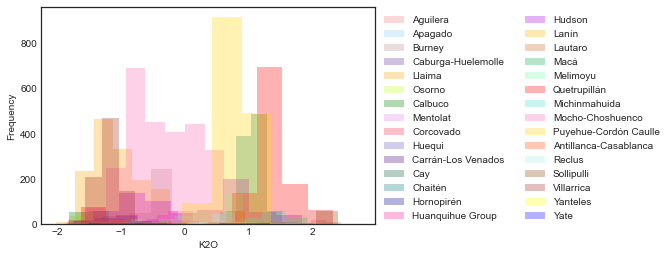

 
Rb
Volcán without information Sollipulli


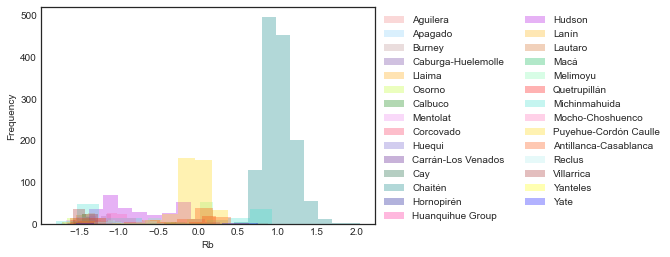

 
Sr
Volcán without information Sollipulli


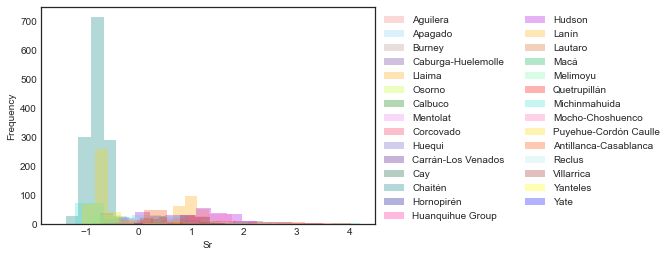

 
Y
Volcán without information Sollipulli


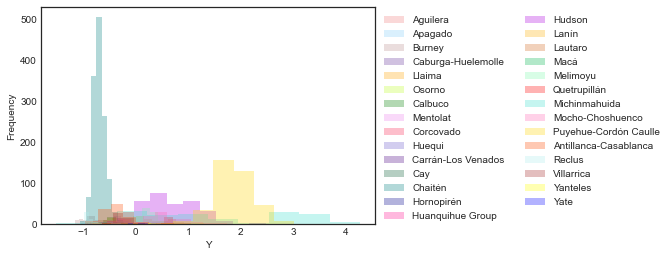

 
Zr
Volcán without information Sollipulli


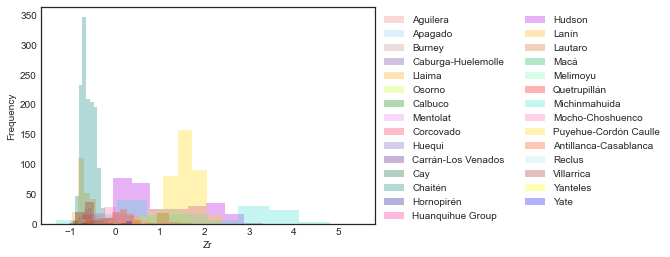

 
Nb
Volcán without information Aguilera
Volcán without information Sollipulli


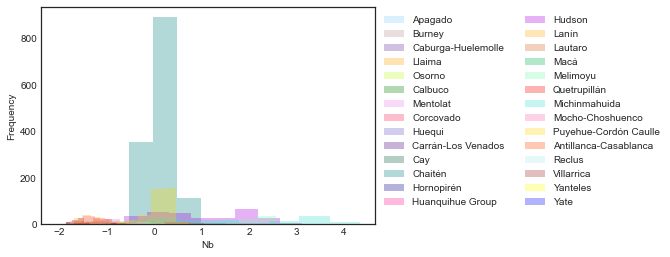

 
Cs
Volcán without information Aguilera
Volcán without information Lautaro
Volcán without information Sollipulli


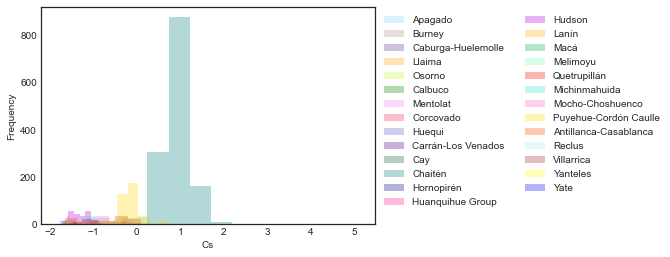

 
Ba
Volcán without information Aguilera
Volcán without information Sollipulli


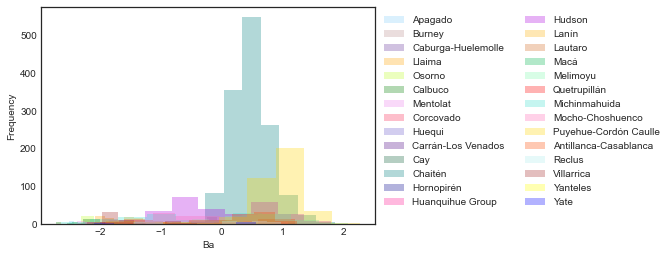

 
La
Volcán without information Aguilera
Volcán without information Sollipulli


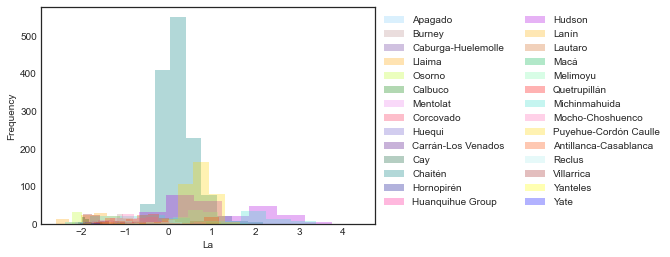

 
Ce
Volcán without information Aguilera
Volcán without information Sollipulli


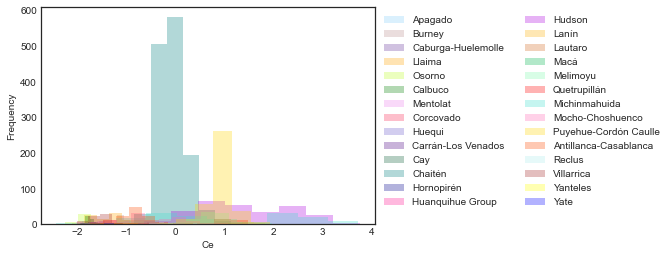

 
Pr
Volcán without information Aguilera
Volcán without information Lanín
Volcán without information Sollipulli
Volcán without information Yanteles


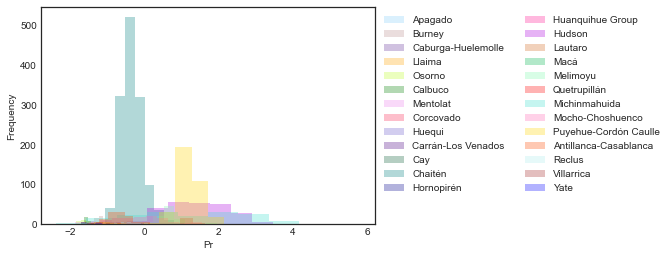

 
Nd
Volcán without information Aguilera
Volcán without information Sollipulli


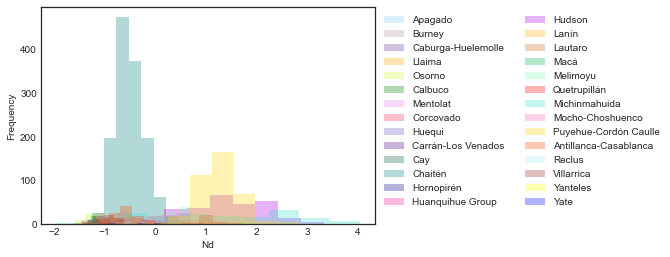

 
Sm
Volcán without information Aguilera
Volcán without information Sollipulli


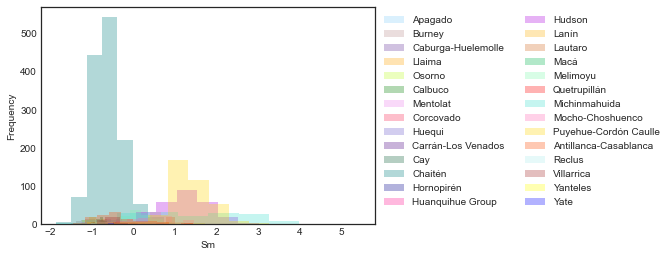

 
Eu
Volcán without information Aguilera
Volcán without information Sollipulli


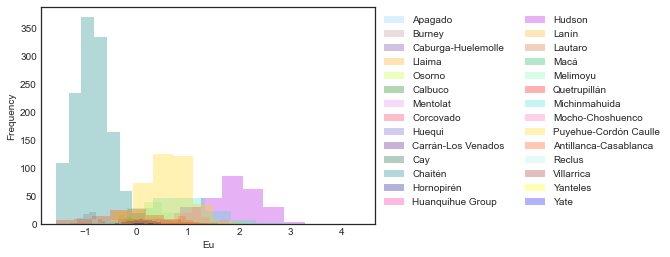

 
Gd
Volcán without information Aguilera
Volcán without information Sollipulli
Volcán without information Yanteles


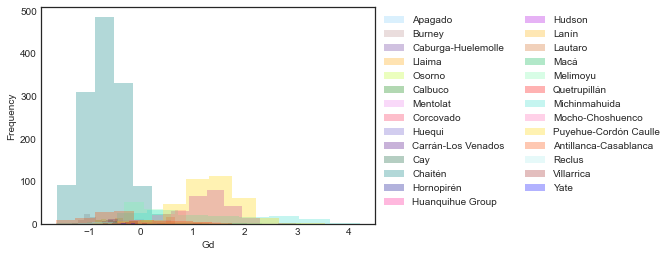

 
Tb
Volcán without information Aguilera
Volcán without information Sollipulli


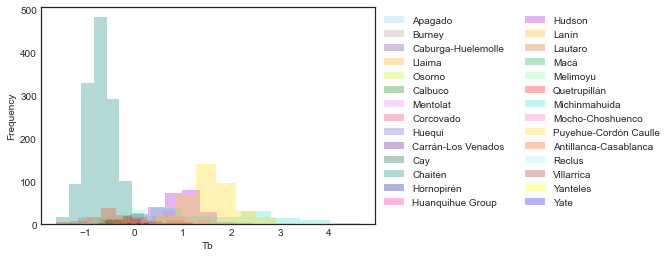

 
Dy
Volcán without information Aguilera
Volcán without information Sollipulli
Volcán without information Yanteles


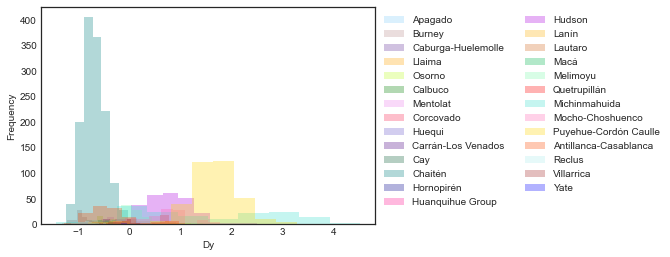

 
Ho
Volcán without information Aguilera
Volcán without information Sollipulli
Volcán without information Yanteles


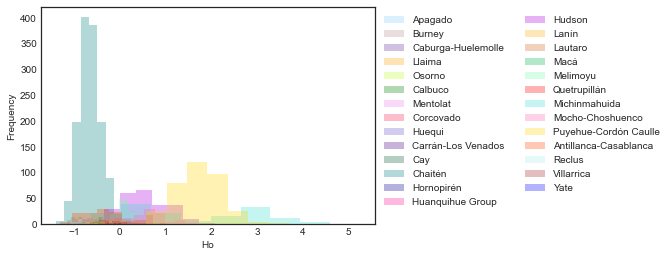

 
Er
Volcán without information Aguilera
Volcán without information Sollipulli
Volcán without information Yanteles


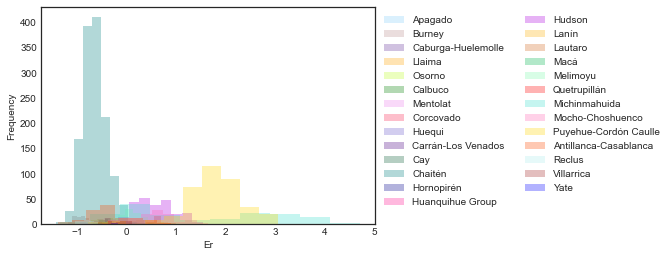

 
Tm
Volcán without information Aguilera
Volcán without information Lanín
Volcán without information Sollipulli
Volcán without information Yanteles


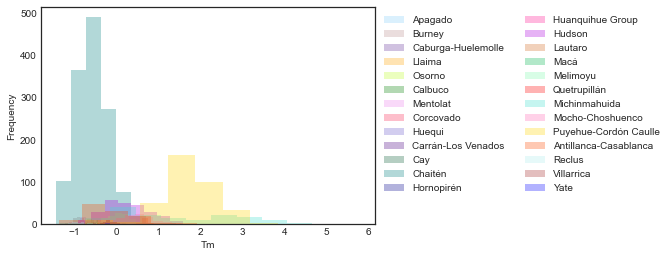

 
Yb
Volcán without information Aguilera
Volcán without information Sollipulli


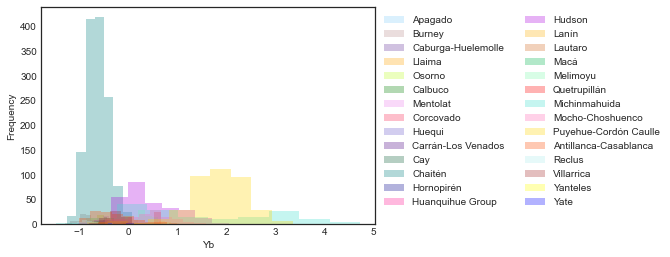

 
Lu
Volcán without information Aguilera
Volcán without information Sollipulli


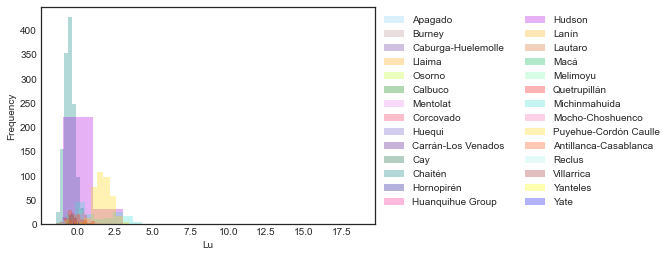

 
Hf
Volcán without information Aguilera
Volcán without information Sollipulli


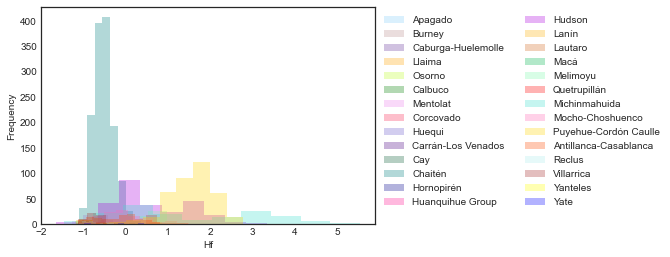

 
Ta
Volcán without information Aguilera
Volcán without information Lanín
Volcán without information Sollipulli


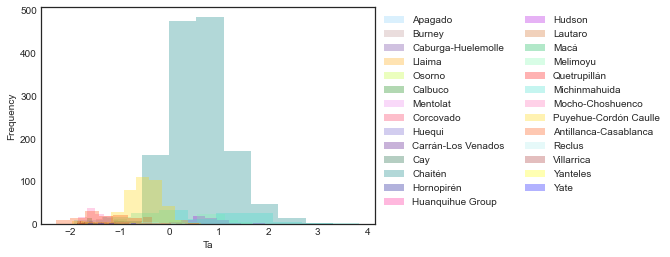

 
Pb
Volcán without information Aguilera
Volcán without information Lanín
Volcán without information Sollipulli
Volcán without information Yanteles


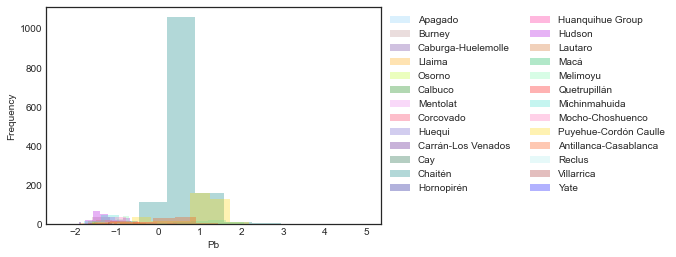

 
Th
Volcán without information Aguilera
Volcán without information Sollipulli


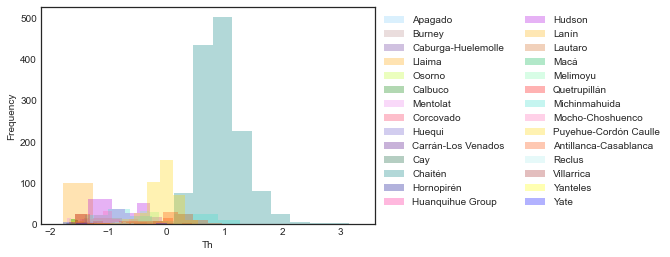

 
U
Volcán without information Aguilera
Volcán without information Lanín
Volcán without information Sollipulli


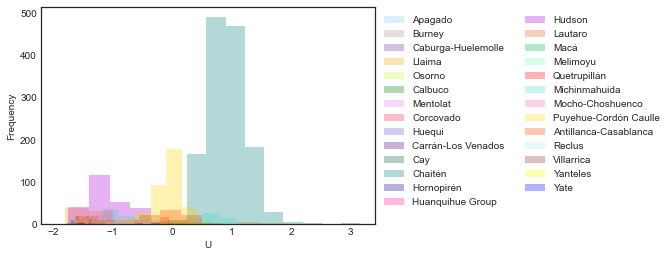

In [65]:
print(df.SiO2.mean(axis=0))
print(df.Sr.mean(axis=0))

sc = StandardScaler()
X_esc = sc.fit_transform(X)
X_esc = pd.DataFrame(X_esc, columns = X.columns)
X_esc['Volcan']=df.Volcan.reset_index(drop=True)
X_esc['Evento']=df.Evento.reset_index(drop=True)

Histogramas(X_esc)

# KNN Imputer

In [33]:
print(X.columns.tolist())
columns2 = X.columns.tolist()

for i in range(len(X.columns.tolist())):
    columns2.append(X.columns.tolist()[i] + '_ms')

print(columns2)

['SiO2', 'TiO2', 'Al2O3', 'FeO*', 'MnO', 'MgO', 'CaO', 'Na2O', 'K2O', 'Rb', 'Sr', 'Y', 'Zr', 'Nb', 'Cs', 'Ba', 'La', 'Ce', 'Pr', 'Nd', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu', 'Hf', 'Ta', 'Pb', 'Th', 'U']
['SiO2', 'TiO2', 'Al2O3', 'FeO*', 'MnO', 'MgO', 'CaO', 'Na2O', 'K2O', 'Rb', 'Sr', 'Y', 'Zr', 'Nb', 'Cs', 'Ba', 'La', 'Ce', 'Pr', 'Nd', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu', 'Hf', 'Ta', 'Pb', 'Th', 'U', 'SiO2_ms', 'TiO2_ms', 'Al2O3_ms', 'FeO*_ms', 'MnO_ms', 'MgO_ms', 'CaO_ms', 'Na2O_ms', 'K2O_ms', 'Rb_ms', 'Sr_ms', 'Y_ms', 'Zr_ms', 'Nb_ms', 'Cs_ms', 'Ba_ms', 'La_ms', 'Ce_ms', 'Pr_ms', 'Nd_ms', 'Sm_ms', 'Eu_ms', 'Gd_ms', 'Tb_ms', 'Dy_ms', 'Ho_ms', 'Er_ms', 'Tm_ms', 'Yb_ms', 'Lu_ms', 'Hf_ms', 'Ta_ms', 'Pb_ms', 'Th_ms', 'U_ms']


In [ ]:
imp = KNNImputer(n_neighbors=10,weights='distance',add_indicator=True)#
X_imp = imp.fit_transform(X)
X_imp = pd.DataFrame(X_imp, columns = columns2)
X_imp_ms = X_imp.loc[:, 'SiO2_ms':'U_ms']
X_imp = X_imp.loc[:, 'SiO2':'U']
prueba = np.multiply(X_imp.values,X_imp_ms.values)
X_only_imp = pd.DataFrame(prueba, columns = X.columns)
X_only_imp = X_only_imp.replace(0,np.nan)

In [ ]:
ind_volcan = np.where((y == y))[0]
graficar_imputing('KNN Imputer', X.iloc[ind_volcan.tolist(),:] ,X_only_imp.iloc[ind_volcan.tolist(),:],y[ind_volcan.tolist()],'SiO2','Sr')
graficar_imputing('KNN Imputer', X.iloc[ind_volcan.tolist(),:] ,X_only_imp.iloc[ind_volcan.tolist(),:],y[ind_volcan.tolist()],'SiO2','La')
graficar_imputing('KNN Imputer', X.iloc[ind_volcan.tolist(),:] ,X_only_imp.iloc[ind_volcan.tolist(),:],y[ind_volcan.tolist()],'Rb','Sr')
graficar_imputing('KNN Imputer', X.iloc[ind_volcan.tolist(),:] ,X_only_imp.iloc[ind_volcan.tolist(),:],y[ind_volcan.tolist()],'SiO2','K2O')

# Iterative Imputer

### Bayesian Ridge

In [ ]:
#Imputing
#sc = StandardScaler()
#X_esc = sc.fit_transform(X)
imp = IterativeImputer(random_state=0,min_value=0,verbose=0,max_iter = 500,
                       estimator=BayesianRidge())#se puede obtener en paralelo una matriz con el missing indicator a partir del atributo "indicator_"
#X_Imp = imp.fit_transform(X_esc)
X_imp = imp.fit_transform(X)
#X_inv = sc.inverse_transform(X_Imp)
#X_imp = pd.DataFrame(X_inv, columns = X.columns)
X_imp = pd.DataFrame(X_imp, columns = X.columns)

In [ ]:
ind_volcan = np.where((y == y))[0]
graficar_imputing(X.iloc[ind_volcan.tolist(),:] ,X_imp.iloc[ind_volcan.tolist(),:],y[ind_volcan.tolist()],'SiO2','Sr')
graficar_imputing(X.iloc[ind_volcan.tolist(),:] ,X_imp.iloc[ind_volcan.tolist(),:],y[ind_volcan.tolist()],'SiO2','La')
graficar_imputing(X.iloc[ind_volcan.tolist(),:] ,X_imp.iloc[ind_volcan.tolist(),:],y[ind_volcan.tolist()],'Rb','Sr')
graficar_imputing(X.iloc[ind_volcan.tolist(),:] ,X_imp.iloc[ind_volcan.tolist(),:],y[ind_volcan.tolist()],'SiO2','K2O')

### ExtraTrees regressor 

In [ ]:
#Imputing
Estimator = ExtraTreesRegressor(random_state=0)#n_estimators=10, 
imp = IterativeImputer(random_state=0,estimator = Estimator,min_value = 0)#se puede obtener en paralelo una matriz con el missing indicator a partir del atributo "indicator_"
X_imp = imp.fit_transform(X)
X_imp = pd.DataFrame(X_imp, columns = X.columns)

In [ ]:
ind_volcan = np.where((y == y))[0]
graficar_imputing(X.iloc[ind_volcan.tolist(),:] ,X_imp.iloc[ind_volcan.tolist(),:],y[ind_volcan.tolist()],'SiO2','Sr')
graficar_imputing(X.iloc[ind_volcan.tolist(),:] ,X_imp.iloc[ind_volcan.tolist(),:],y[ind_volcan.tolist()],'SiO2','La')
graficar_imputing(X.iloc[ind_volcan.tolist(),:] ,X_imp.iloc[ind_volcan.tolist(),:],y[ind_volcan.tolist()],'Rb','Sr')
graficar_imputing(X.iloc[ind_volcan.tolist(),:] ,X_imp.iloc[ind_volcan.tolist(),:],y[ind_volcan.tolist()],'SiO2','K2O')

### RandomForest Regressor

C:\Users\consu\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


Text(0.5, 1.0, 'Imputed data: Bayesian Ridge')

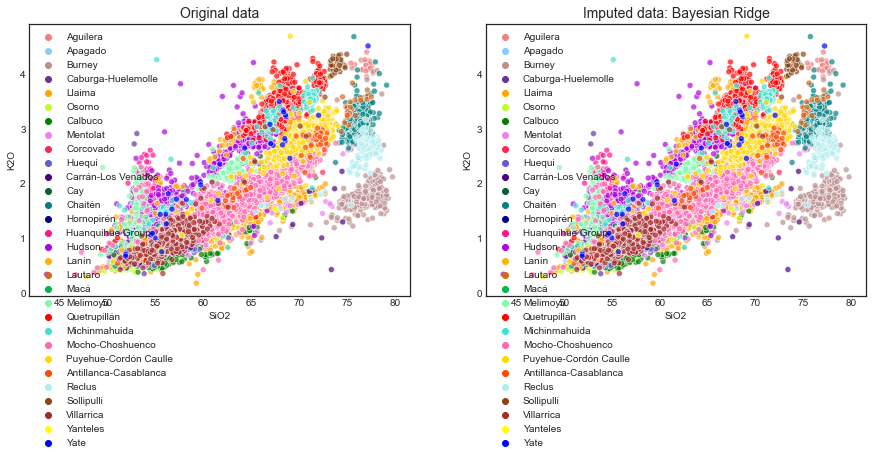

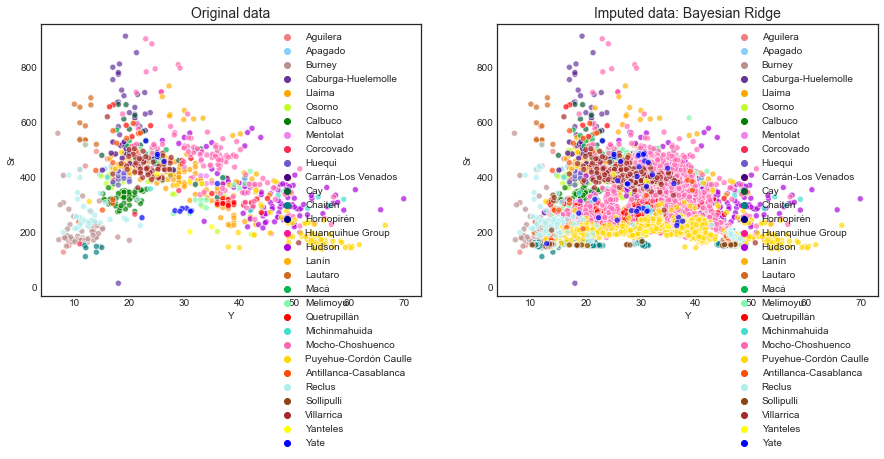

In [32]:
Estimator = RandomForestRegressor(n_estimators=150,min_samples_leaf=1, min_samples_split=5,bootstrap='False',random_state=0)#n_estimators=10, 
imp = IterativeImputer(random_state=0,estimator = Estimator,min_value = 0)#se puede obtener en paralelo una matriz con el missing indicator a partir del atributo "indicator_"
X_imp = imp.fit_transform(X)
X_imp = pd.DataFrame(X_imp, columns = X.columns)
dpal = Colores(y)

In [ ]:
ind_volcan = np.where((y == y))[0]
graficar_imputing(X.iloc[ind_volcan.tolist(),:] ,X_imp.iloc[ind_volcan.tolist(),:],y[ind_volcan.tolist()],'SiO2','Sr')
graficar_imputing(X.iloc[ind_volcan.tolist(),:] ,X_imp.iloc[ind_volcan.tolist(),:],y[ind_volcan.tolist()],'SiO2','La')
graficar_imputing(X.iloc[ind_volcan.tolist(),:] ,X_imp.iloc[ind_volcan.tolist(),:],y[ind_volcan.tolist()],'Rb','Sr')
graficar_imputing(X.iloc[ind_volcan.tolist(),:] ,X_imp.iloc[ind_volcan.tolist(),:],y[ind_volcan.tolist()],'SiO2','K2O')

### DesicionTreeRegressor

In [44]:
Estimator = DecisionTreeRegressor(random_state=0)#n_estimators=10, 
imp = IterativeImputer(random_state=0,estimator = Estimator,max_iter=50,min_value = 0,verbose =1)#se puede obtener en paralelo una matriz con el missing indicator a partir del atributo "indicator_"
X_imp = imp.fit_transform(X)
X_imp = pd.DataFrame(X_imp, columns = X.columns)

[IterativeImputer] Completing matrix with shape (14072, 35)
[IterativeImputer] Change: 1066.0189371834288, scaled tolerance: 1.04 
[IterativeImputer] Change: 754.9231492562194, scaled tolerance: 1.04 
[IterativeImputer] Change: 1017.7082890395093, scaled tolerance: 1.04 
[IterativeImputer] Change: 1144.4616632672664, scaled tolerance: 1.04 
[IterativeImputer] Change: 1054.2509607647883, scaled tolerance: 1.04 
[IterativeImputer] Change: 1268.4298187910363, scaled tolerance: 1.04 
[IterativeImputer] Change: 1395.6531607651089, scaled tolerance: 1.04 
[IterativeImputer] Change: 1187.3557534035915, scaled tolerance: 1.04 
[IterativeImputer] Change: 1278.895182071939, scaled tolerance: 1.04 
[IterativeImputer] Change: 1277.228791327367, scaled tolerance: 1.04 
[IterativeImputer] Change: 1279.6871189519716, scaled tolerance: 1.04 
[IterativeImputer] Change: 1057.3831219659291, scaled tolerance: 1.04 
[IterativeImputer] Change: 1270.7902978837258, scaled tolerance: 1.04 
[IterativeImputer] C

KeyboardInterrupt: 

In [ ]:
ind_volcan = np.where((y == y))[0]
graficar_imputing(X.iloc[ind_volcan.tolist(),:] ,X_imp.iloc[ind_volcan.tolist(),:],y[ind_volcan.tolist()],'SiO2','Sr')
graficar_imputing(X.iloc[ind_volcan.tolist(),:] ,X_imp.iloc[ind_volcan.tolist(),:],y[ind_volcan.tolist()],'SiO2','La')
graficar_imputing(X.iloc[ind_volcan.tolist(),:] ,X_imp.iloc[ind_volcan.tolist(),:],y[ind_volcan.tolist()],'Rb','Sr')
graficar_imputing(X.iloc[ind_volcan.tolist(),:] ,X_imp.iloc[ind_volcan.tolist(),:],y[ind_volcan.tolist()],'SiO2','K2O')

### Kenighbohrs Regressor

In [ ]:
# sc = StandardScaler()
#X_esc = sc.fit_transform(X)
#print(X_esc)
start = time.time()
Estimator = KNeighborsRegressor(n_neighbors = 100,weights='distance',p=2 )#n_estimators=10,     
imp = IterativeImputer(random_state=0,estimator = Estimator,min_value = 0,verbose=1,max_iter = 50)#se puede obtener en paralelo una matriz con el missing indicator a partir del atributo "indicator_"
X_imp = imp.fit_transform(X)
#X_inv = sc.inverse_transform(X_Imp)
X_imp = pd.DataFrame(X_imp, columns = X.columns)
end = time.time()
print(end-start)

[IterativeImputer] Completing matrix with shape (13386, 35)
[IterativeImputer] Change: 666.3681283473913, scaled tolerance: 1.04 
[IterativeImputer] Change: 436.6833368734999, scaled tolerance: 1.04 
[IterativeImputer] Change: 405.84562974803305, scaled tolerance: 1.04 
[IterativeImputer] Change: 102.63917130804417, scaled tolerance: 1.04 
[IterativeImputer] Change: 50.581439624110025, scaled tolerance: 1.04 
[IterativeImputer] Change: 44.59384684788006, scaled tolerance: 1.04 
[IterativeImputer] Change: 38.97411091272023, scaled tolerance: 1.04 
[IterativeImputer] Change: 37.9093662394667, scaled tolerance: 1.04 
[IterativeImputer] Change: 41.106442612806454, scaled tolerance: 1.04 
[IterativeImputer] Change: 35.72932051506374, scaled tolerance: 1.04 
[IterativeImputer] Change: 33.78560010139829, scaled tolerance: 1.04 
[IterativeImputer] Change: 35.70297982349814, scaled tolerance: 1.04 
[IterativeImputer] Change: 38.97949059963879, scaled tolerance: 1.04 
[IterativeImputer] Change: 

C:\Users\consu\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\consu\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\consu\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\consu\anaconda3\

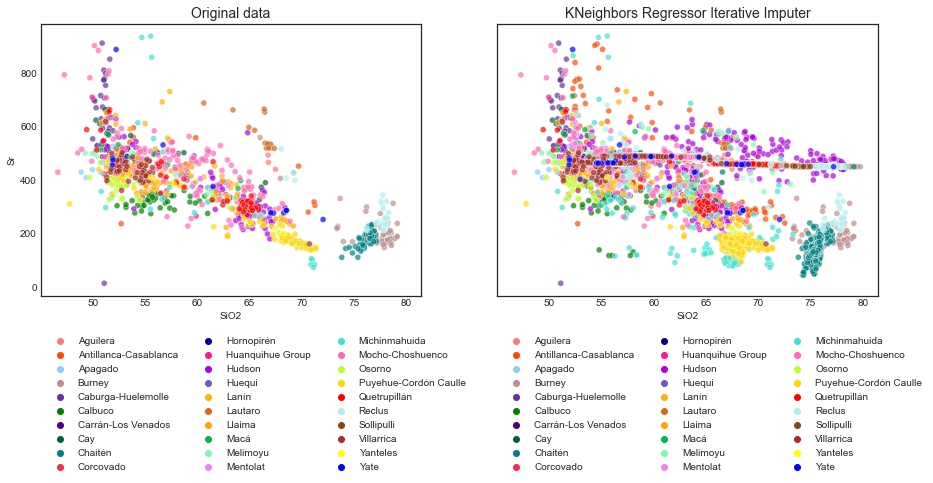

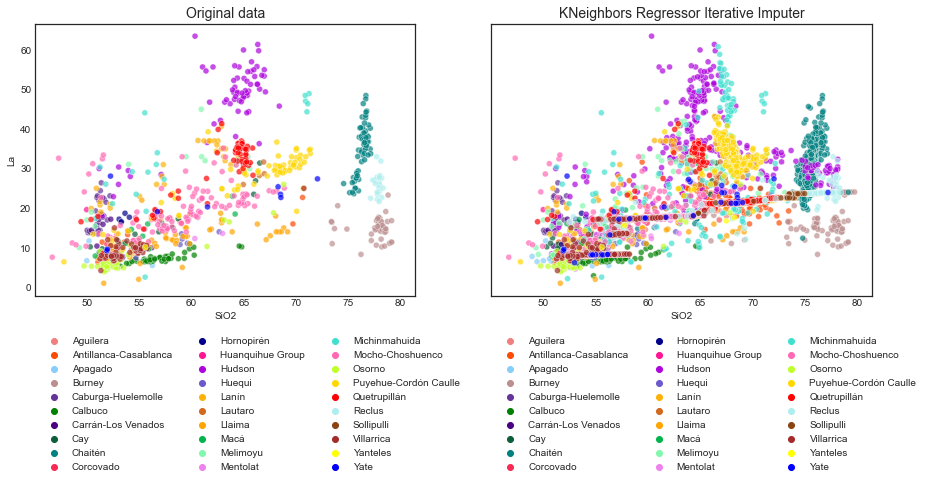

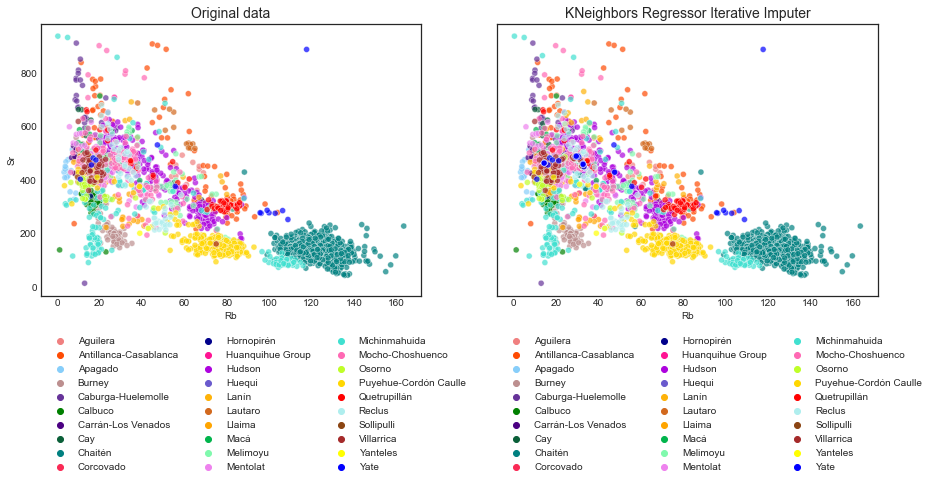

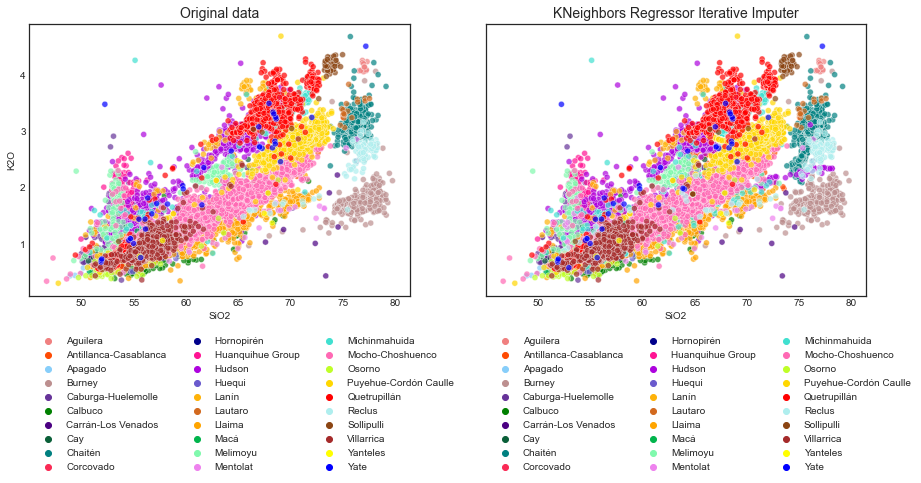

In [22]:
ind_volcan = np.where((y == y))[0]
graficar_imputing('KNeighbors Regressor Iterative Imputer', X.iloc[ind_volcan.tolist(),:] ,X_imp.iloc[ind_volcan.tolist(),:],y[ind_volcan.tolist()],'SiO2','Sr')
graficar_imputing('KNeighbors Regressor Iterative Imputer', X.iloc[ind_volcan.tolist(),:] ,X_imp.iloc[ind_volcan.tolist(),:],y[ind_volcan.tolist()],'SiO2','La')
graficar_imputing('KNeighbors Regressor Iterative Imputer', X.iloc[ind_volcan.tolist(),:] ,X_imp.iloc[ind_volcan.tolist(),:],y[ind_volcan.tolist()],'Rb','Sr')
graficar_imputing('KNeighbors Regressor Iterative Imputer', X.iloc[ind_volcan.tolist(),:] ,X_imp.iloc[ind_volcan.tolist(),:],y[ind_volcan.tolist()],'SiO2','K2O')